<a href="https://colab.research.google.com/github/JyothiNandhan/XAI_ACM_PROJECT/blob/main/Copy_of_project_acm_finalSwim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [07:45<00:00, 22.2MB/s]
100% 9.51G/9.51G [07:45<00:00, 21.9MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/aptos2019-blindness-detection.zip')
zip_ref.extractall('/content/APTOS2019_Dataset')
zip_ref.close()

In [ ]:
pip install torch torchvision timm tqdm lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
from timm import create_model
from lime import lime_image
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 32
learning_rate = 1e-4
num_epochs = 5
num_classes = 5  # Update this to the actual number of classes in your dataset

# Paths to training dataset and labels
train_images_path = '/content/APTOS2019_Dataset/train_images'  # Update this path to your training dataset
labels_csv_path = '/content/APTOS2019_Dataset/train.csv'  # Update this path to your labels CSV file

# Dataset preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 as required by many models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_csv, transform=None):
        self.images_dir = images_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform
        self.extensions = ['.png', '.jpg', '.jpeg']  # Possible image extensions

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        image_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]

        # Check for possible file extensions
        for ext in self.extensions:
            image_path = os.path.join(self.images_dir, image_name + ext)
            if os.path.exists(image_path):
                break
        else:
            raise FileNotFoundError(f"Image file not found for {image_name} with extensions {self.extensions}")

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Use custom dataset
train_dataset = CustomDataset(images_dir=train_images_path, labels_csv=labels_csv_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model definition
class SwinTransformerTransfer(nn.Module):
    def __init__(self, num_classes):
        super(SwinTransformerTransfer, self).__init__()
        self.vgg_backbone = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.swin_transformer = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        # Pass input through VGG16 backbone (feature extraction, not directly used in this approach)
        _ = self.vgg_backbone(x)  # This line is just to illustrate usage, not connected to the final output

        # Directly pass the original input to Swin Transformer
        x = self.swin_transformer(x)
        return x

# Initialize model, loss function, and optimizer
model = SwinTransformerTransfer(num_classes=num_classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Training Complete")

# LIME Integration
def predict(image):
    model.eval()
    image = transform(image).unsqueeze(0).cuda()
    with torch.no_grad():
        output = model(image)
    return torch.nn.functional.softmax(output, dim=1).cpu().numpy()

def lime_explanation(image_path):
    explainer = lime_image.LimeImageExplainer()
    image = Image.open(image_path).convert('RGB')
    explanation = explainer.explain_instance(np.array(image), predict, top_labels=num_classes, hide_color=0, num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)

    plt.imshow(img_boundry1)
    plt.title(f'Explanation for class: {explanation.top_labels[0]}')
    plt.show()

# Example usage of LIME on a specific image
example_image_path = '/content/APTOS2019_Dataset/train_images/example_image.png'  # Update this path to an example image
lime_explanation(example_image_path)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 224MB/s]


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 115/115 [07:34<00:00,  3.95s/it]


Epoch [1/5] - Loss: 0.6856, Accuracy: 74.09%


Epoch 2/5: 100%|██████████| 115/115 [07:29<00:00,  3.91s/it]


Epoch [2/5] - Loss: 0.4786, Accuracy: 82.14%


Epoch 3/5: 100%|██████████| 115/115 [07:31<00:00,  3.93s/it]


Epoch [3/5] - Loss: 0.3817, Accuracy: 85.45%


Epoch 4/5: 100%|██████████| 115/115 [07:31<00:00,  3.92s/it]


Epoch [4/5] - Loss: 0.3275, Accuracy: 87.52%


Epoch 5/5: 100%|██████████| 115/115 [07:31<00:00,  3.93s/it]

Epoch [5/5] - Loss: 0.2863, Accuracy: 89.60%
Training Complete


FileNotFoundError: [Errno 2] No such file or directory: '/content/APTOS2019_Dataset/train_images/example_image.png'

  0%|          | 0/1000 [00:00<?, ?it/s]

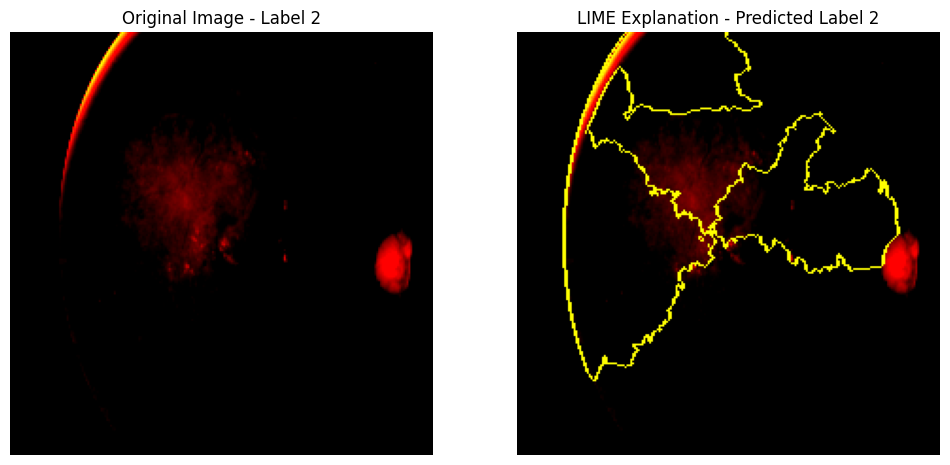

  0%|          | 0/1000 [00:00<?, ?it/s]

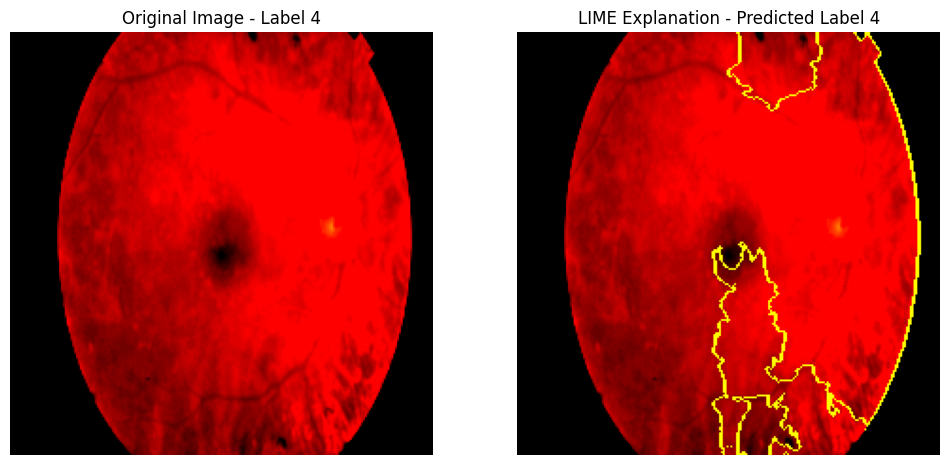

  0%|          | 0/1000 [00:00<?, ?it/s]

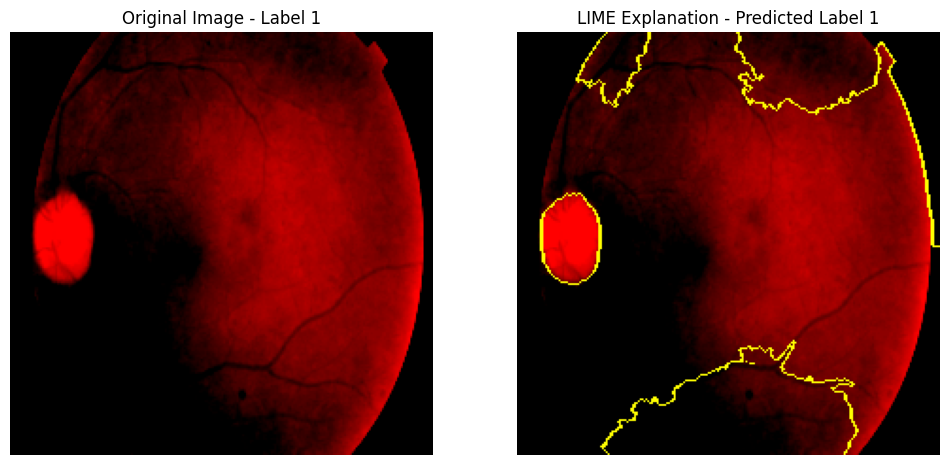

  0%|          | 0/1000 [00:00<?, ?it/s]

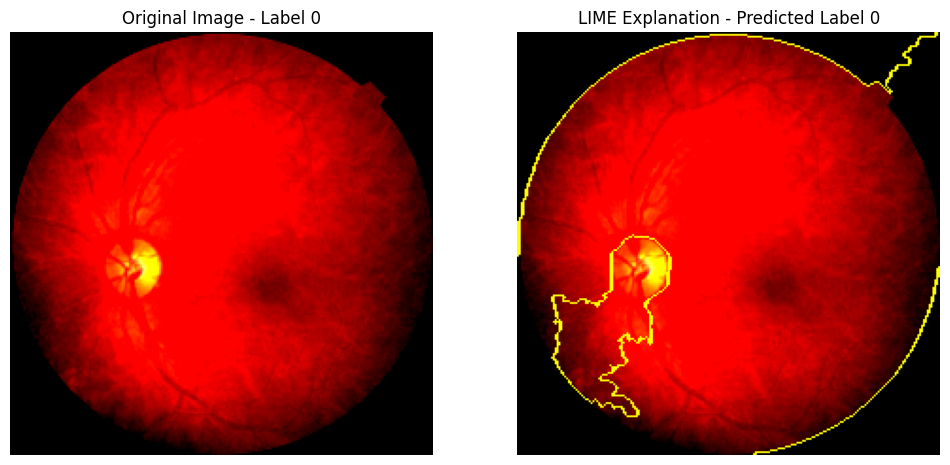

  0%|          | 0/1000 [00:00<?, ?it/s]

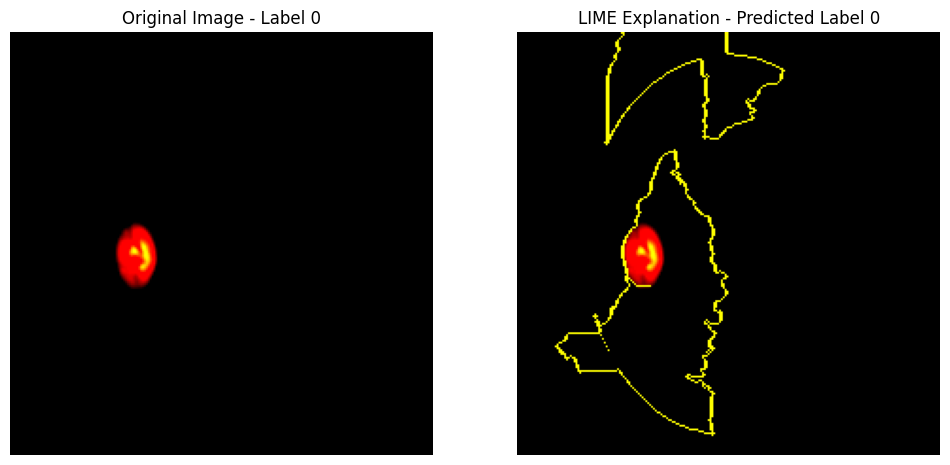

  0%|          | 0/1000 [00:00<?, ?it/s]

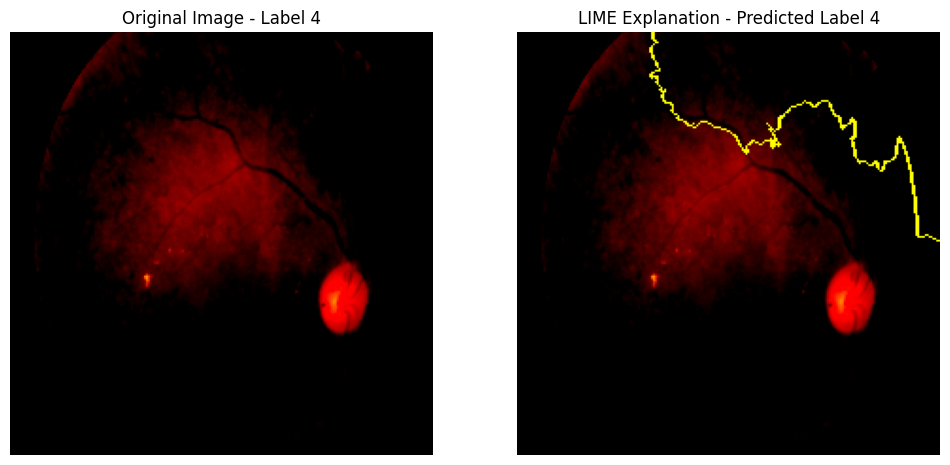

  0%|          | 0/1000 [00:00<?, ?it/s]

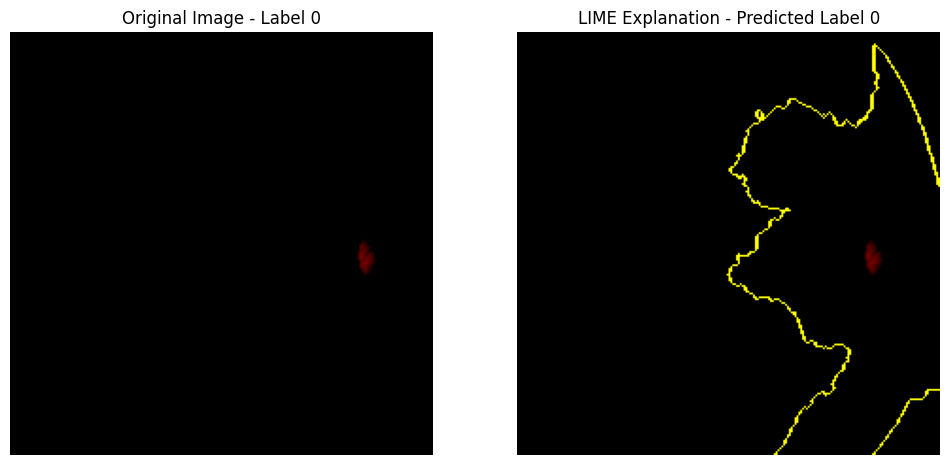

  0%|          | 0/1000 [00:00<?, ?it/s]

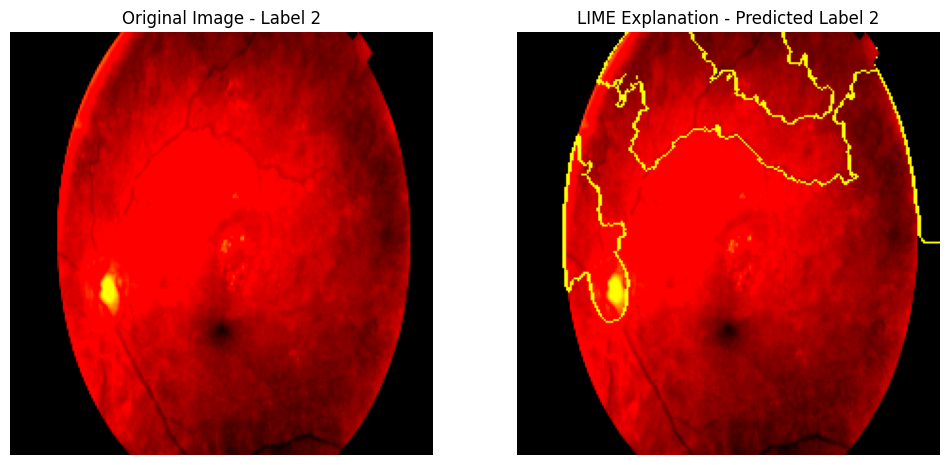

  0%|          | 0/1000 [00:00<?, ?it/s]

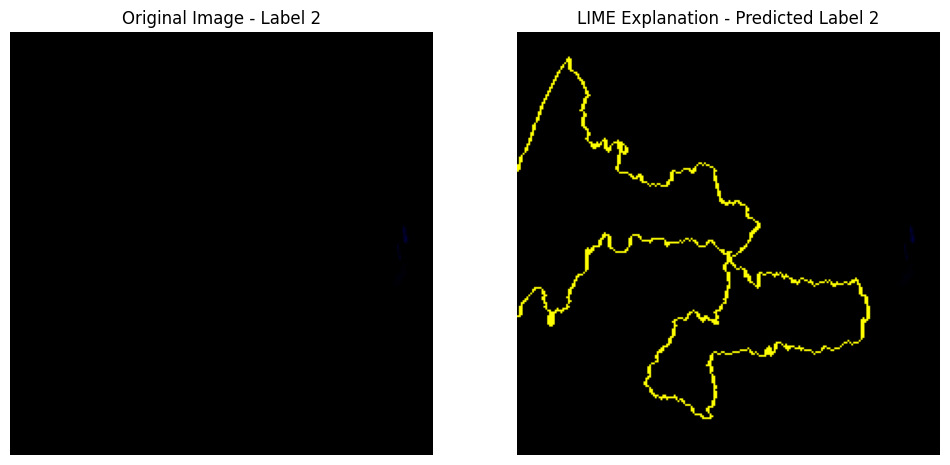

  0%|          | 0/1000 [00:00<?, ?it/s]

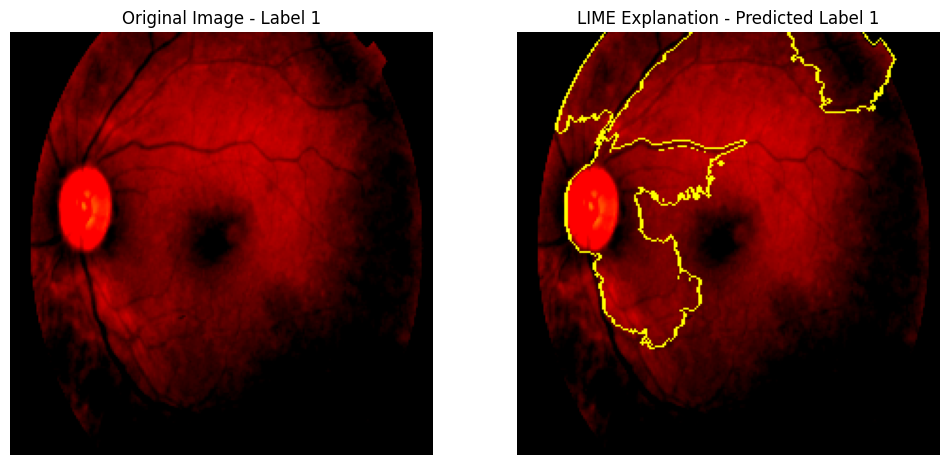

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ensure your model is set to evaluation mode
model.eval()

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define prediction function for LIME
def predict(images):
    images = torch.stack([transforms.ToTensor()(image).to(device) for image in images])
    outputs = model(images)
    return outputs.detach().cpu().numpy()

def batch_predict(images):
    return predict(images)

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain the first 10 images in the dataset
for i in range(10):
    image, label = train_loader.dataset[i]
    image_np = image.permute(1, 2, 0).numpy()

    explanation = explainer.explain_instance(image_np, batch_predict, top_labels=1, hide_color=0, num_samples=1000)

    top_label = explanation.top_labels[0]  # Get the top predicted label
    temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=False)

    # Blend the original image with the LIME mask
    img_boundry1 = mark_boundaries(image_np, mask)

    # Plot original image with LIME highlights
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image_np)
    ax[0].set_title(f'Original Image - Label {label}')
    ax[0].axis('off')

    ax[1].imshow(img_boundry1)
    ax[1].set_title(f'LIME Explanation - Predicted Label {top_label}')
    ax[1].axis('off')

    plt.show()
